In [1]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import os
import multiprocessing
from pathlib import Path
import itertools
from tqdm import tqdm

from utils.DomainImageGenerator import DomainImageGenerator

2025-07-16 13:25:57.457112: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-16 13:25:57.460939: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-16 13:25:57.472480: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752665157.490892  644369 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752665157.496392  644369 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-07-16 13:25:57.516423: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU ins

In [2]:
cpu_count = multiprocessing.cpu_count()
n_jobs = int(cpu_count * 0.9) # Just set to use some percent of cpus

In [3]:
train_gen = DomainImageGenerator("prepared/train.csv", batch_size=64, img_size=(32, 32), shuffle=False, n_jobs=n_jobs) # "batch_size=64, img_size=(32, 32), shuffle=True]" are the default values
val_gen = DomainImageGenerator("prepared/valid.csv", batch_size=64, img_size=(32, 32), shuffle=False, n_jobs=n_jobs)
test_gen = DomainImageGenerator("prepared/test.csv", batch_size=64, img_size=(32, 32), shuffle=False, n_jobs=n_jobs)


train_gen.shuffle_indexes()
train_indexes = train_gen.return_Indexes()
X_train = train_gen.return_Img_by_Index(train_indexes)
y_train = train_gen.return_Label_by_Index(train_indexes)

val_gen.shuffle_indexes()
val_indexes = val_gen.return_Indexes()
X_val = val_gen.return_Img_by_Index(val_indexes)
y_val = val_gen.return_Label_by_Index(val_indexes)

test_gen.shuffle_indexes()
test_indexes = test_gen.return_Indexes()
X_test = test_gen.return_Img_by_Index(test_indexes)
y_test = test_gen.return_Label_by_Index(test_indexes)

Loading images: 100%|███████████████████| 90000/90000 [00:51<00:00, 1734.24it/s]


In [4]:
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_val_flat = X_val.reshape(X_val.shape[0], -1)
X_test_flat = X_test.reshape(X_val.shape[0], -1)

X_combined_train_flat = np.concatenate([X_train_flat, X_val_flat])
y_combined_train = np.concatenate([y_train, y_val])

Already tested:  
param_grid = {
    "n_estimators": [100, 150],
    "max_depth": [None, 10, 20],
    "min_samples_split": [2, 5, 10],
    "max_features": ["sqrt", "log2"],
    "criterion": ["gini", "entropy", "log_loss"]
}

output  
Model 1: Accuracy = 0.7853
Params:
  n_estimators: 100
  max_depth: 20
  min_samples_split: 5
  max_features: sqrt
  criterion: entropy
    

Model 2: Accuracy = 0.7853
Params:
  n_estimators: 100
  max_depth: 20
  min_samples_split: 5
  max_features: sqrt
  criterion: log_loss

Model 3: Accuracy = 0.7852
Params:
  n_estimators: 100
  max_depth: 20
  min_samples_split: 10
  max_features: sqrt
  criterion: entropy

In [5]:
# Define search space 
param_grid = {
    "n_estimators": [100],
    "max_depth": [20, 30],
    "min_samples_split": [5, 10],
    "max_features": ["sqrt"],
    "criterion": ["entropy", "log_loss"]
}

# This for just using one
param_grid = {
    "n_estimators": [100],
    "max_depth": [20],
    "min_samples_split": [5],
    "max_features": ["sqrt"],
    "criterion": ["entropy"]
}

# Track best models
results = []

# Create all parameter combinations
param_combos = list(itertools.product(
    param_grid["n_estimators"],
    param_grid["max_depth"],
    param_grid["min_samples_split"],
    param_grid["max_features"],
    param_grid["criterion"]
))

# Search
for n_estimators, max_depth, min_samples_split, max_features, criterion in tqdm(param_combos, desc="Training models"):

    clf = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        max_features=max_features,
        criterion=criterion,
        n_jobs=n_jobs,
        random_state=42
    )

    clf.fit(X_combined_train_flat, y_combined_train)
    y_pred = clf.predict(X_test_flat)
    acc = accuracy_score(y_test, y_pred)

    results.append({
        "accuracy": acc,
        "params": {
            "n_estimators": n_estimators,
            "max_depth": max_depth,
            "min_samples_split": min_samples_split,
            "max_features": max_features,
            "criterion": criterion
        },
        "model": clf
    })

# Sort by accuracy
results.sort(key=lambda x: x["accuracy"], reverse=True)

# Show top 3
print("\nTop 3 Random Forest Configurations:")
for i, result in enumerate(results[:3], 1):
    print(f"\nModel {i}: Accuracy = {result['accuracy']:.4f}")
    print("Params:")
    for k, v in result["params"].items():
        print(f"  {k}: {v}")

Training models: 100%|████████████████████████████| 1/1 [00:44<00:00, 44.24s/it]


Top 3 Random Forest Configurations:

Model 1: Accuracy = 0.7853
Params:
  n_estimators: 100
  max_depth: 20
  min_samples_split: 5
  max_features: sqrt
  criterion: entropy


In [6]:
model1 = results[0]["model"]

In [7]:
y_pred = model1.predict(X_test_flat)

In [8]:
print(classification_report(y_test, y_pred, target_names=["CIFAR-10", "ImageNet"]))

              precision    recall  f1-score   support

    CIFAR-10       0.92      0.04      0.07     20000
    ImageNet       0.78      1.00      0.88     70000

    accuracy                           0.79     90000
   macro avg       0.85      0.52      0.47     90000
weighted avg       0.81      0.79      0.70     90000



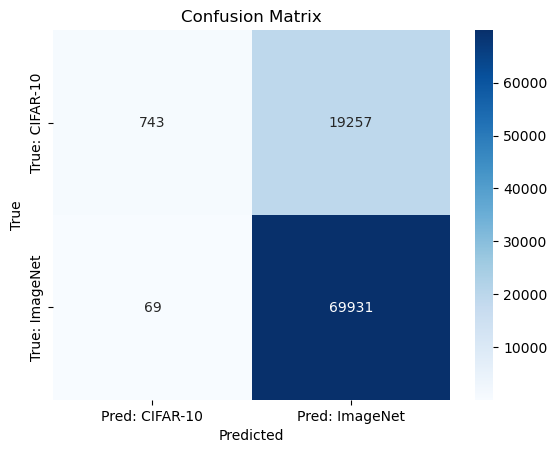

In [9]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Pred: CIFAR-10", "Pred: ImageNet"],
            yticklabels=["True: CIFAR-10", "True: ImageNet"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()